In [1]:
import os
import scipy
from scipy.signal import butter, lfilter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from single_photons.simulation.simulation_particle import simulation_p
import single_photons.utils.constants as ct
from single_photons.environment import Particle
from single_photons.utils.parameters import *
from single_photons.utils.metrics import *
from control import lqr,dare
from tqdm import tqdm

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 12
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['figure.dpi'] = 200#600
C = ['#2E86C1', '#85C1E9', '#1B4F72']

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [19]:
basic_sample = 0
basic_phonons = 0
trajectory_bool = 1
numbers_acquire_bool = 0
numbers_process_bool = 0

main = os.getcwd()

delta_t = 4e-9
control_step = int(32e-9/delta_t)
omega = 2*np.pi*104e3
period = 2*np.pi/omega
t = np.arange(0, 1800 * period, delta_t)
N = t.shape[0]
g_fb_ratio = [2*np.pi*110e3/omega, 2*np.pi*8e3/omega]

p = 9.2e-7
radius = 71.5e-9
wavelength = 1.064e-6
power = 300e-3
waist = 3.7352e-6 #from scattered power in Magrini paper. resulting theoretical omega is 56% the experimental one
eta_detection = 0.34
fs = 1/(control_step*delta_t)

In [16]:
gamma, ba_force, std_detection, std_z = compute_parameters_simulation(power, wavelength, waist, omega,
                                                                      radius, p, fs, eta_detection)
coupling = (1/(4*np.pi))*(ba_force**2)
env = Particle(omega, gamma, coupling, eta_detection=eta_detection, radius = radius)
std_detection = std_detection/env.zp_x
variance_process = env.thermal_force_std**2 + env.backaction_std**2
Q = np.array([[0, 0], [0, variance_process]])*control_step*delta_t/2
R = np.array([[np.power(std_detection,2)]])
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0],
                        [0, omega/2]])

g_fb = g_fb_ratio[0]*omega
r = omega/g_fb**2
X, L, G_fb = dare(Ad, Bd, cost_states, r)
if trajectory_bool:
    g_fb = g_fb_ratio[1]*omega
    r = omega/g_fb**2
    X, L, G_fb_1 = dare(Ad, Bd, cost_states, r)

In [17]:
x0 = 0
P0 = std_detection**2

if trajectory_bool or basic_sample or basic_phonons:
    new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_p(
        env.A,
        env.B, 
        env.thermal_force_std,
        env.backaction_std, 
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        G_fb,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )

if trajectory_bool:
    new_states_1 , measured_states_1, estimated_states_1, cov_aposteriori_1, controls_1 = simulation_p(
        env.A,
        env.B, 
        env.thermal_force_std,
        env.backaction_std, 
        std_detection, 
        eta_detection,
        x0, 
        P0, 
        Ad, 
        Bd, 
        env.C, 
        env.G,
        G_fb_1,
        Q, 
        R, 
        delta_t, 
        control_step, 
        N
    )

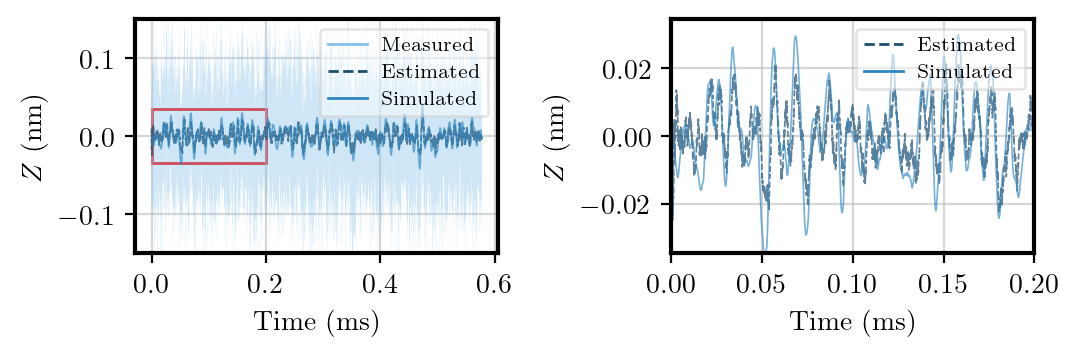

In [18]:
if basic_sample:
    '''Parameters for last run of this,
    delta_t = 4e-9
    control_step = int(32e-9/delta_t)
    omega = 2*np.pi*104e3
    period = 2*np.pi/omega
    t = np.arange(0, 1800 * period, delta_t)
    N = t.shape[0]
    g_fb_ratio = [2*np.pi*110e3/omega, 2*np.pi*8e3/omega]
    
    p = 9.2e-7
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 300e-3
    waist = 3.7352e-6 #from scattered power in Magrini paper. resulting theoretical omega is 56% the experimental one
    eta_detection = 0.34
    fs = 1/(control_step*delta_t)'''
    factor = 1.57
    fig, ax = plt.subplots(1, 2, figsize = (3.5*factor,1.2*factor))
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.linewidth'] = 1.5
    ax[0].grid(alpha = 0.5)
    ax[0].plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*measured_states[:int(N/30):control_step], color = C[1], alpha = 0.4,
             linewidth = 0.05, label = 'Measured')
    ax[0].plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*estimated_states[:int(N/30):control_step,0], color = C[2], alpha = 0.7,
             linestyle = 'dashed', linewidth = 0.6, label = 'Estimated')
    ax[0].plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*new_states[:int(N/30):control_step,0], color = C[0], alpha = 0.65, linewidth = 0.6, label = 'Simulated')
    leg_0 = ax[0].legend(fontsize = 7, loc = 'upper right')
    leg_0.get_frame().set_alpha(0.5)
    for lh in leg_0.legend_handles: 
        lh.set_alpha(1)
        lh.set_linewidth(1)
    ax[0].set_ylim([-0.15, 0.15])
    ax[0].set_ylabel(r'$Z$ (nm)')
    ax[0].set_xlabel(r'Time (ms)')
    rect = patches.Rectangle((0, -0.0345), 0.2, 0.069, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    ax[1].grid(alpha = 0.5)
    ax[1].set_xlim([0, 0.2])
    ax[1].set_ylim([-0.0345, 0.0345])
    ax[1].set_ylabel(r'$Z$ (nm)')
    ax[1].set_xlabel(r'Time (ms)')
    ax[1].plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*estimated_states[:int(N/30):control_step,0], color = C[2], alpha = 0.7,
             linestyle = 'dashed', linewidth = 0.6, label = 'Estimated')
    ax[1].plot(1e3*t[:int(N/30):control_step],env.zp_x*1e9*new_states[:int(N/30):control_step,0], color = C[0], alpha = 0.65, linewidth = 0.6, label = 'Simulated')
    leg_1 = ax[1].legend(fontsize = 7, loc = 'upper right')
    leg_1.get_frame().set_alpha(0.5)
    for lh in leg_1.legend_handles: 
        lh.set_alpha(1)
        lh.set_linewidth(1)

    plt.tight_layout()
    plt.savefig('simulation_sample_mech.pdf', dpi = 600)

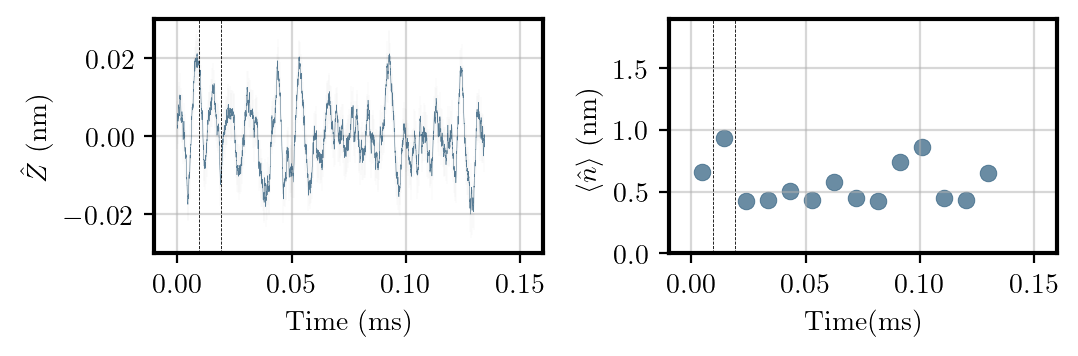

In [14]:
if basic_phonons:
    '''Parameters for latest run of this,
    delta_t = 4e-9
    control_step = int(32e-9/delta_t)
    omega = 2*np.pi*104e3
    period = 2*np.pi/omega
    t = np.arange(0, 5000 * period, delta_t)
    N = t.shape[0]
    g_fb_ratio = [2*np.pi*110e3/omega, 2*np.pi*8e3/omega]
    
    p = 9.2e-7
    radius = 71.5e-9
    wavelength = 1.064e-6
    power = 300e-3
    waist = 3.7352e-6 #from scattered power in Magrini paper. resulting theoretical omega is 56% the experimental one
    eta_detection = 0.34
    fs = 1/(control_step*delta_t)'''
    
    factor = 1.57
    fig, ax = plt.subplots(1, 2, figsize = (3.5*factor,1.2*factor))
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.linewidth'] = 1.5
    
    duration = int(15*period/delta_t)
    t_crop = t[-duration::control_step] - t[-duration]
    estimate_crop = estimated_states[-duration::control_step]
    measure_crop = measured_states[-duration::control_step]
    cov_crop = cov_aposteriori[-int(duration/control_step):]
    errors = np.sqrt(cov_crop[:,0,0])
    step=int(1*period/(delta_t*control_step))
    phonons = compute_phonons(estimate_crop, cov_crop, 1, step=step)
    window_pick = 1
        
    t_1 = 1e3*delta_t*control_step*step*window_pick
    t_2 = t_1 + 1e3*delta_t*control_step*step

    ax[0].grid(alpha = 0.5)
    ax[0].plot(1e3*(t_crop[:step*phonons.shape[0]]), 1e9*env.zp_x*estimate_crop[:step*phonons.shape[0],0],
               color = C[2], alpha = 0.7, linewidth = 0.2)
    ax[0].errorbar(1e3*(t_crop[:step*phonons.shape[0]][::10]), 1e9*env.zp_x*estimate_crop[:step*phonons.shape[0],0][::10],
                   yerr = 1e9*env.zp_x*errors[:step*phonons.shape[0]][::10], color = 'black', alpha = 0.15, linewidth = 0.05)
    ax[0].set_ylabel(r'$\hat{Z}$ (nm)')
    ax[0].set_xlabel(r'Time (ms)')
    ax[0].set_ylim([-0.03, 0.03])
    ax[0].set_xlim([-0.01, 0.16])

    ax[1].grid(alpha = 0.5)
    ax[1].scatter(1e3*(-1.5*delta_t*control_step*step + t_crop[::step][-phonons.shape[0]:]), phonons, linewidth = 0.3, color = C[2], alpha = 0.65)
    ax[1].set_ylabel(r'$\langle \hat{n} \rangle$ (nm)')
    ax[1].set_xlabel(r'Time(ms)')
    ax[1].set_ylim([0, 1.9])
    ax[1].set_yticks(np.arange(0,1.6,0.5))
    ax[1].set_xlim([-0.01, 0.16])

    ax[0].plot([t_1, t_1],ax[0].get_ylim(), color = 'black', linestyle = 'dashed', linewidth = 0.3)
    ax[0].plot([t_2, t_2],ax[0].get_ylim(), color = 'black', linestyle = 'dashed', linewidth = 0.3)
    ax[1].plot([t_1, t_1],ax[1].get_ylim(), color = 'black', linestyle = 'dashed', linewidth = 0.3)
    ax[1].plot([t_2, t_2],ax[1].get_ylim(), color = 'black', linestyle = 'dashed', linewidth = 0.3)
    
    #plt.plot([0, 1e3*t_crop[-1]], 2*[(eta_detection**(-0.5) - 1) / 2], linewidth = 1, color = 'black', alpha = 0.5, linestyle = 'dashed')
    #plt.yticks(np.arange(0.0,2.5,0.4))
    #plt.ylim([0,2.5])
    #plt.yscale('log')
    plt.tight_layout()
    #plt.savefig('phonons_mech.pdf', dpi = 600)

In [21]:
if trajectory_bool:
    df = pd.DataFrame()
    df['z'] = butter_bandpass_filter(estimated_states[:,0][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=1)[430000:]
    df['p'] = butter_bandpass_filter(estimated_states[:,1][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=1)[430000:]
    df[r'$g_{fb}/2\pi$'] = len(df)*['110 kHz']

    df_1 = pd.DataFrame()
    df_1['z'] = butter_bandpass_filter(estimated_states_1[:,0][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=1)[430000:]
    df_1['p'] = butter_bandpass_filter(estimated_states_1[:,1][::control_step], 22e3, 220e3, 1/(control_step*delta_t), order=1)[430000:]
    df_1[r'$g_{fb}/2\pi$'] = len(df_1)*['8.0 kHz']
    
    df = pd.concat([df_1,df])

C:\Users\calif\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\calif\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\calif\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\calif\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

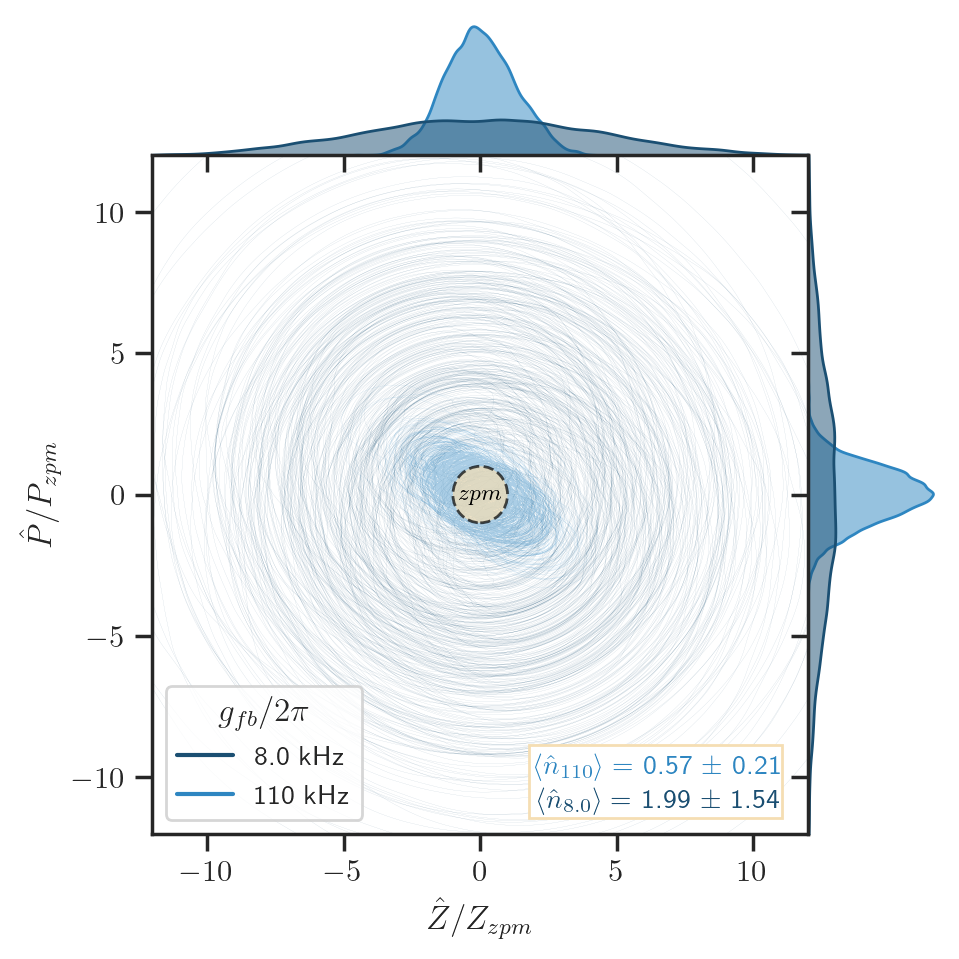

In [25]:
if trajectory_bool:
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.linewidth'] = 1.5
    factor = 1.4
    
    #circle_r = 1
    phn_step = 208#int(step/12)
    phn_nmb = 25#int(20*step/phn_step)
    d = np.linspace(0,2*np.pi,1600)
    #x,y = circle_r*np.cos(d), circle_r*np.sin(d)
    n_0 = compute_phonons(estimated_states, cov_aposteriori, control_step, step=phn_step)[-phn_nmb:]
    n_1 = compute_phonons(estimated_states_1, cov_aposteriori_1, control_step, step=phn_step)[-phn_nmb:]
    sns.set_theme(style="white")
    sns.set_style("ticks",{'axes.grid' : False, 'font.size' : 10})
    g = sns.JointGrid(data=df, x="z", y="p", hue = r'$g_{fb}/2\pi$', xlim=[-12,12], ylim=[-12,12],
                      space = 0, marginal_ticks = False, palette = sns.set_palette(C[-1::-2]), height = factor*3.5)
    g.plot_joint(sns.lineplot, sort = False, alpha = 0.4,linewidth = 0.05)
    g.set_axis_labels(r'$\hat{Z}/Z_{zpm}$',r'$\hat{P}/P_{zpm}$', fontsize = 12)
    plt.xticks(np.linspace(-10,10,5), fontsize = 10)
    plt.yticks(np.linspace(-10,10,5), fontsize = 10)
    g.plot_marginals(sns.kdeplot, alpha=0.5, fill=True)
    #g.ax_joint.plot(x,y, linestyle = 'dashed', color = 'black')
    #g.set_edgecolor('black')  
    #g.set_linewidth(1)  
    text1 = r'$\langle \hat{n}_{110} \rangle =$' + ' {:.2f}'.format(np.mean(n_0)) + r' $\pm$ ' + '{:.2f}'.format(np.std(n_0))
    text2 = r'$\langle \hat{n}_{8.0} \rangle =$' + ' {:.2f}'.format(np.mean(n_1)) + r' $\pm$ ' + '{:.2f}'.format(np.std(n_1))
    text3 = r'$zpm$'
    circle = patches.Circle((0,0), 1, linewidth = 1, linestyle = 'dashed', edgecolor = 'black', facecolor = 'wheat', fill = 1, alpha = 0.7, zorder = 5)
    rect = patches.Rectangle((1.8, -11.45), 9.25, 2.6, linewidth=1, edgecolor = 'wheat', facecolor = 'white', fill = 1, zorder = 5)#edgecolor='black', facecolor = 'whitesmoke', alpha = 1)

    g.ax_joint.add_patch(circle)
    g.ax_joint.add_patch(rect)
    sns.move_legend(g.ax_joint, loc = 'lower left', fontsize = 10)
    plt.text(-0.45,-9.87,text1, color = C[0], fontsize = 10)
    plt.text(-0.445,-11.07,text2, color = C[2], fontsize = 10)
    plt.text(-0.5765,-0.21,text3, color = 'black', fontsize = 8)
    plt.savefig('phase_space.pdf', dpi = 600, bbox_inches = 'tight')

In [ ]:
if numbers_acquire_bool:
    numbers_mean = []
    numbers_std = []
    x0 = std_detection
    P0 = std_detection**2
    g_fb_list = 2e3*np.pi*np.linspace(1,25,25)#np.concatenate((np.linspace(1.5,6,4),np.linspace(8,156,12)))
    for g in tqdm(g_fb_list):
        r = omega/g**2
        X, L, G_fb = dare(Ad, Bd, cost_states, r)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_p(
            env.A,
            env.B, 
            env.thermal_force_std,
            env.backaction_std, 
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            G_fb,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        n = compute_phonons(estimated_states, cov_aposteriori, control_step, step=350)[-20:-1]
        numbers_mean.append(np.mean(n))
        numbers_std.append(np.std(n))
    numbers_mean = np.array(numbers_mean)
    numbers_std = np.array(numbers_std)
    data = {'mean': numbers_mean,
           'std': numbers_std,
           'gain': g_fb_list,
           'eta': np.array(len(numbers_mean)*[eta_detection])}
    df = pd.DataFrame(data)
    if 'data_numbers.pkl' in os.listdir(main):
        df_main = pd.read_pickle('data_numbers.pkl')
        df = pd.concat([df_main,df])
    df.to_pickle('data_numbers.pkl')

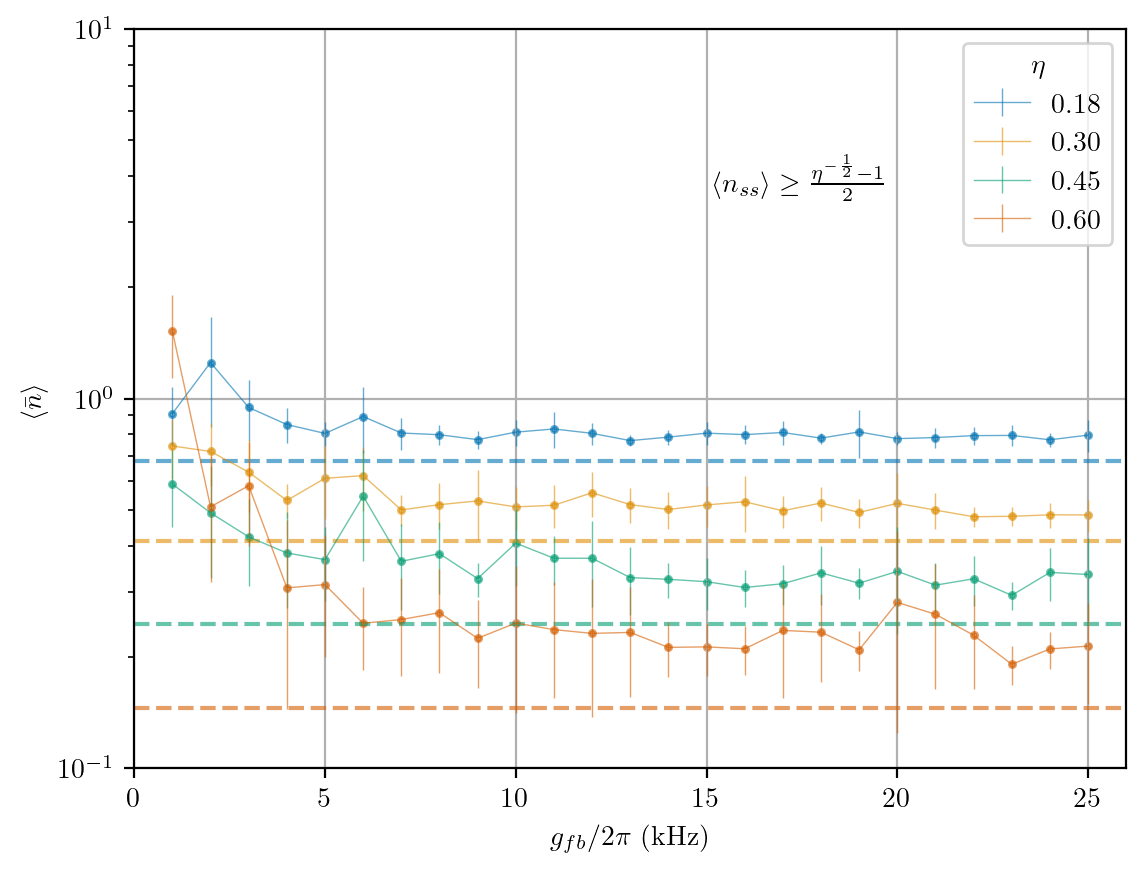

In [17]:
if numbers_process_bool:
    colors = sns.color_palette('colorblind')
    df = pd.read_pickle('data_numbers.pkl')
    etas = df['eta'].unique()
    line = []
    count = 0
    
    for el in etas:
        x = df[df['eta'] == el]['gain'].values
        y = df[df['eta'] == el]['mean'].values
        error = df[df['eta'] == el]['std'].values
        if el > 0.60:
            continue
        xmax = (x[0] + x[-1])/(2e3*np.pi)
        if count == 0:
            fig,ax = plt.subplots()
            ax.set_xlim(0, xmax)
            ax.set_ylim(0.1,10)
            ax.set_xlabel(r'$g_{fb}/2\pi$ (kHz)')
            ax.set_ylabel(r'$\langle \bar{n} \rangle$')
            ax.set_yscale('log')
            plt.text(15.2, 3.65, r'$\langle n_{ss} \rangle \geq \frac{\eta^{-\frac{1}{2}}-1}{2}$')
        plt.scatter(x/(2e3*np.pi),y, s = 5, color = colors[count], alpha = 0.6)
        line.append(ax.errorbar(x/(2e3*np.pi),y,error, color = colors[count], linewidth = 0.5, alpha = 0.6))
        line[-1].set_label('{:.2f}'.format(el))
        plt.plot([0, xmax], 2*[(1/np.sqrt(el) - 1)/2], linestyle = '--', color = colors[count], alpha = 0.6)
        count += 1
    ax.legend(title = r'$\eta$')
    plt.grid()
    plt.savefig('number_gain.pdf', dpi = 600)

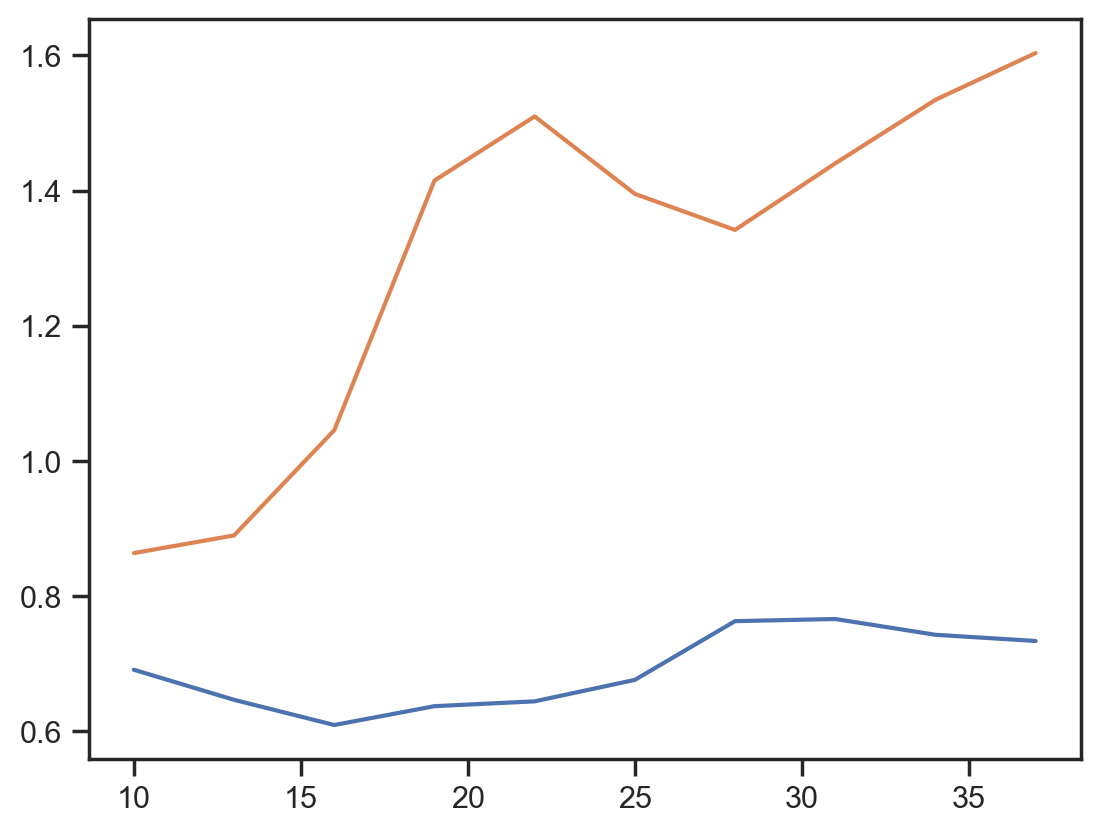

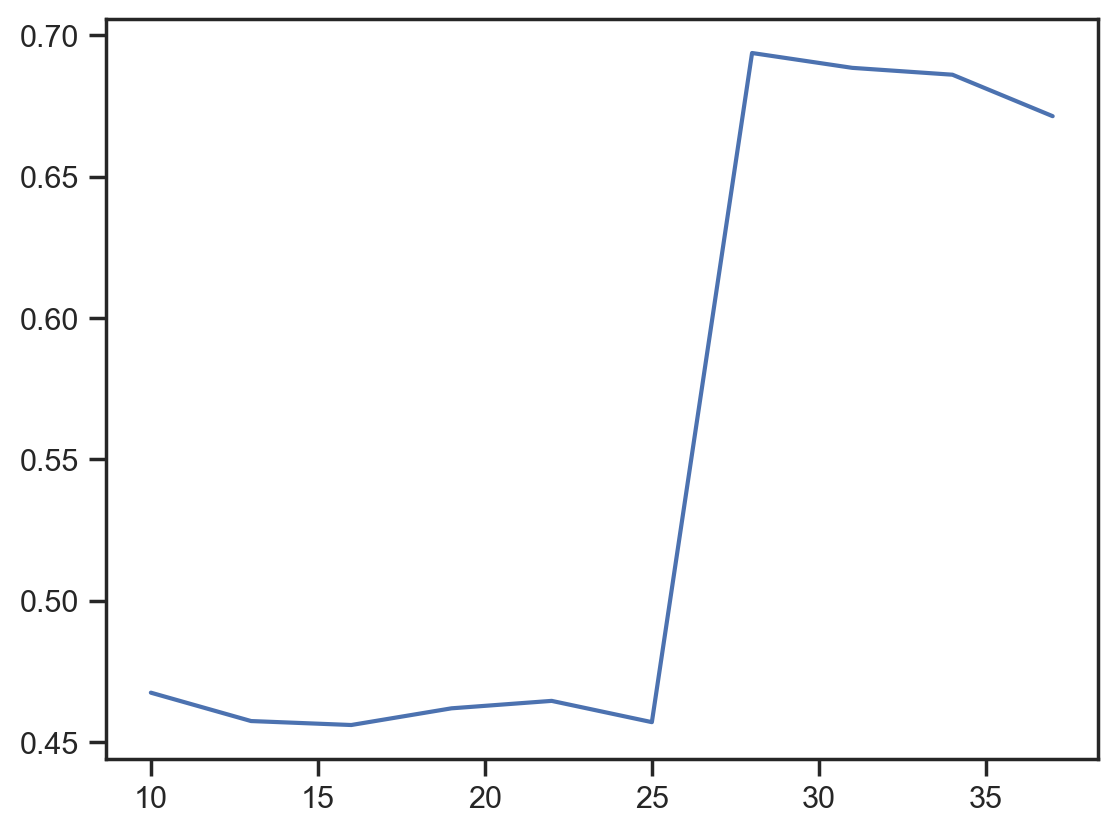

In [28]:
phn_step = np.arange(200,280,8)
stp = 208
phn_nmb = np.arange(10,40,3)
num = 20
data_0 = []
data_1 = []
data_2 = []

X = phn_nmb
#X = phn_step
for num in phn_nmb:
#for stp in phn_step:
    n_0 = compute_phonons(estimated_states, cov_aposteriori, control_step, step=stp)[-num:]
    n_1 = compute_phonons(estimated_states_1, cov_aposteriori_1, control_step, step=stp)[-num:]
    data_0.append(np.mean(n_0))
    data_2.append(np.mean(n_1))
    data_1.append(np.std(n_0) / np.mean(n_0))

plt.figure()
plt.plot(X,data_0)
plt.plot(X,data_2)
plt.figure()
plt.plot(X,data_1)